### Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

In [2]:
#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

# import auxiliar functions
%autoreload 2
from Auxiliary import *

### Input variables

In [26]:
''' Silicon 111 crystal '''
# dafault crystal parameters
d_sp = 3.13557135638            # reflecting plane d-spacing [A]
psi0r = -5.11321939903e-05      # real part of 0th Fourier component of crystal polarizability
psi0i = 3.58887560736e-06       # imaginary part of ""
psi_hr = -2.71341902391e-05     # real part of Hth Fourier component
psi_hi = 2.50565837652e-06      # imaginary part of ""
psi_hbr = -2.71341902391e-05    # real part of -Hth Fourier coumponent
psi_hbi = 2.50565837652e-06     # imaginary part of ""
tc = 0.01                       # crystal thickness
ang_as = np.deg2rad(5)          # asymmetric angle
uc = 1                          # use case: 1 (Bragg reflection); 2 (Bragg transmission)

ang_dif_pl = 0                  # diffraction plane angle: 0 (vertical); pi/2 (horizontal)
Temp_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

# lens parameters (PMMA)
n = 1 - 5.89e-6         # material refractive index
d_abs = 788e-6          # material absorption depth
f_lens = 1.0            # lens focal distance

# aperture parameters
Apt_width = 1e-3        # aperture width (1D)
acentx = 0              # center of aperture [m]
acenty = 0

''' incident beam variables '''
ekev = 6.742                # photon energy [kev]
pulse_duration = 1.e-15     # pulse duration (rms) [t]
z1 = 140.1                  # distance to first OE [m]
sigX = 5e-6                 # w0 (rms) [m]
npoints = 2000              # wavefront sampling dimension
if_load_input = 0           # load (1) or generate (0) incident wavefront

# default values
qnC = 0.1                   # charge [nC]
pulseEnergy = 0.5e-3        # pulse energy [J]
dt = 5e-16                  # time sampling resolution
hbar = 6.582119569e-16

# input dimensions
npointsx = 2                # number of points vs horizontal position
npointsy = npoints          # """"""""""""""""""  vertical position

### Calculate sampling parameters

In [27]:
''' calculations '''
wl0 = E2L(ekev*1e3)                 # wavelength
k0 = 2*np.pi/wl0                    # wavenumber
divergence = wl0/np.pi/sigX         # paraxial beam divergence (rms)
range_xy = divergence/2 * z1 * 5      # spatial sampling range (5 sigma)

nvx0, nvy0, nvz0 = Temp_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][2]
thetaB0 = np.arctan(-nvz0/nvy0)+ang_as

trange = calc_stretching(thetaB0, ang_as, range_xy)    # stretched pulse duration (3 sigma)
dev = 1/trange * 2*np.pi * hbar     # photon energy sampling resolution
nz = int(trange/dt)              # number of photon energy slices
if nz % 2!=0:
    nz += 1
pulseRange = trange/pulse_duration

''' diffraction limit and focal spot Rayleigh range '''
thetamax = 2*np.arctan(Lens_width/f_lens)
dlim = wl0/2/n/np.sin(thetamax)     # diffraction limit
zR = 1/2 * k0 * dlim**2             # focal spot Rayleigh range

print('beam parameters:\n    {}keV, {}fs, {}um w0, {}urad divergence'.format(
    ekev, round(pulse_duration*1e15,2), round(sigX*1e6,2), round(divergence*1e6,2)))
print('sampling parameters:\n    {}fs dt, {}meV deV, {} nz, {} pulseRange'.format(
    round(dt*1e15,2), round(dev*1e3,2), nz, round(pulseRange,2)))
print('other parameters:\n    Bragg angle {}deg, stretched pulse length {}fs'.format(round(np.rad2deg(thetaB0),2),round(trange*1e15,2)))

beam parameters:
    6.742keV, 1.0fs, 5.0um w0, 11.72urad divergence
sampling parameters:
    0.5fs dt, 1.24meV deV, 6696 nz, 3347.74 pulseRange
other parameters:
    Bragg angle 17.06deg, stretched pulse length 3347.74fs


### Generate incident wavefront

generating incident wavefront
saving incident wavefront
finished in 13.46s
R-space


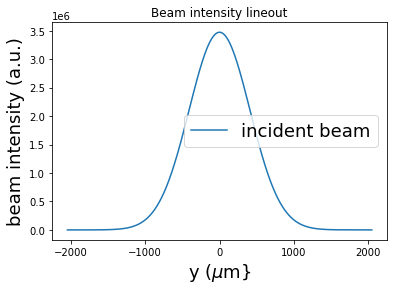

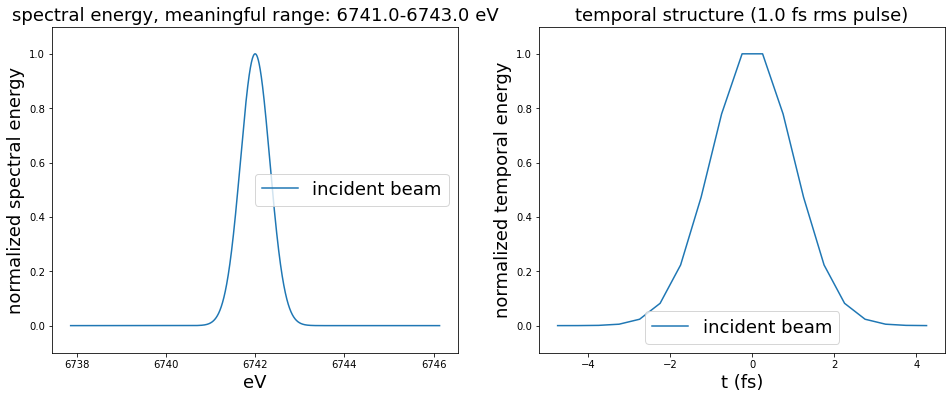

In [28]:
''' directories '''
# output data directory
strDataFolderName = 'WPG_output/Hasan_Mono/' 
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

# sub-folder for current sampling parameters
dirname_duration = strDataFolderName+'{}kev_{}fs_beam_dt={}fs_dev={}meV/'.format(
    ekev,round(pulse_duration*1e15,1),round(dt*1e15,2),round(dev*1e3,2))
if not os.path.exists(dirname_duration):
    mkdir_p(dirname_duration)

# sub-sub-folder for incident beam
dirname_input = dirname_duration+'incident_beam/'
if not os.path.exists(dirname_input):
    mkdir_p(dirname_input)

fname_incident = dirname_input + 'incident_wavefront.h5'

''' load or generate '''
tstart = time.time()
if if_load_input ==1:
    print('loading incident wavefront')
    mwf = Wavefront()
    try:
        mwf.load_hdf5(fname_incident)
    except:
        if_load_input = 0
        print("incident wavefront doesn't exist")

if if_load_input != 1:
    print('generating incident wavefront')
    wfr0 = build_gauss_wavefront(npointsx, npointsy, nz, ekev, -range_xy/2, range_xy/2,
                                    -range_xy/2, range_xy/2 ,pulse_duration, sigX, sigX, z1,
                                    pulseEn=pulseEnergy,pulseRange=pulseRange)

    mwf = Wavefront(wfr0)
    srwl.SetRepresElecField(mwf._srwl_wf, 'f')
    print('saving incident wavefront'.format(round(time.time()-tstart,2)))
    mwf.store_hdf5(fname_incident)
print('finished in {}s'.format(round(time.time()-tstart,2)))

''' plot incident beam structure '''
# spatial profile
if min([npointsx, npointsy])>=4:
    plot_spatial(mwf)
    plt.title('Incident beam', fontsize=18)
else:
    plot_lineout(mwf, label='incident beam', if_log=0)
    plt.title('Beam intensity lineout')

# spectra
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
aw, evI, intIs = plot_spectra(mwf, label='incident beam')
eStart = mwf._srwl_wf.mesh.eStart
eFin = mwf._srwl_wf.mesh.eFin

# temporal profile
plt.subplot(1,2,2)
aw, tI, intIt = plot_temporal(mwf, label='incident beam', fov=pulse_duration*10, pulse_duration=pulse_duration)


### Define beamline optics

In [29]:
%autoreload 2
from Optics import *
tstart = time.time()

''' beamline crystals '''
ang_as0 = 0                 # asymmetry angle of the first crystal
ang_as1 = np.deg2rad(5)     # """""""""""""""""""""" second crystal
ang_as2 = 0                 # """""""""""""""""""""" third crystal
ang_as3 = np.deg2rad(-5)    # """""""""""""""""""""" 4th crystal

OE_Crystal0 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as0,_uc=uc)
OE_Crystal1 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as1,_uc=uc)
OE_Crystal2 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as2,_uc=uc)
OE_Crystal3 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as3,_uc=uc)

''' crystal orientation '''
set_crystal_orient(OE_Crystal0, ekev*1e3, ang_dif_pl)
set_crystal_orient(OE_Crystal1, ekev*1e3, ang_dif_pl)
set_crystal_orient(OE_Crystal2, ekev*1e3, ang_dif_pl)
set_crystal_orient(OE_Crystal3, ekev*1e3, ang_dif_pl)

''' lens calculation '''
Lens_width = range_xy   # lens aperture size
print('calculating OPD and transmission')
Lens_Apt = SRWLOptA('r','a',Lens_width,Lens_width)
Lens_Tr = SRWLOptT(npoints,npoints,Lens_width,Lens_width,_Fx=f_lens,_Fy=f_lens,_x=0,_y=0,_eStart=eStart,_eFin=eFin)

Lens_x = np.linspace(-Lens_width/2,Lens_width/2,npoints)
Lens_x, Lens_y = np.meshgrid(Lens_x,Lens_x)
Lens_z = Perfect_lens(Lens_x,Lens_y,n,f_lens)
Calc_OPD_and_AmpTr(Lens_Tr, Lens_z, n,d_abs)

print('done in {}s'.format(round(time.time()-tstart,2)))

''' aperture '''
OE_Apt = SRWLOptA('r','a',_Dx=range_xy,_Dy=Apt_width,_x=acentx, _y=acenty)


calculating OPD and transmission
done in 7.86s


### Define beamline

In [30]:
''' propagation distance '''
z2 = 0.03		# distance between crystal 0 and 1
z3 = 0.02		# distance between crystal 1 and lens 0
z4 = f_lens		# distance between lens 0 and slit
z5 = f_lens		# distance between slit and lens 1
z6 = z3		    # distance between lens 1 and crystal 2
z7 = z2			# distance between crystal 2 and 3
z8 = 1			# distance between crystal 3 and detector

dirname_prop = dirname_duration+'propagation/'
if not os.path.exists(dirname_prop):
    mkdir_p(dirname_prop)

''' propagation parameters '''
#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#              [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11]
ppCrystal0 =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC0 =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppCrystal1 =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC1 =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppLens_Apt =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppLens_Tr =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftL =     [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppApt =        [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftApt =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppCrystal2 =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC2 =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppCrystal3 =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC3 =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

''' beamlines '''
DriftCrystal0 = SRWLOptD(z2)    # crystal 0 to 1
BL0 = SRWLOptC([OE_Crystal0, DriftCrystal0], [ppCrystal0, ppDriftC0])

DriftCrystal1 = SRWLOptD(z3)    # crystal 1 to lens 0
BL1 = SRWLOptC([OE_Crystal1, DriftCrystal1], [ppCrystal1, ppDriftC1])

DriftLens0 = SRWLOptD(z4)       # lens 0 to slit
BL2 = SRWLOptC([Lens_Apt, Lens_Tr, DriftLens0], [ppLens_Apt, ppLens_Tr, ppDriftL])

DriftApt = SRWLOptD(z5)         # slit to lens 1
BL3 = SRWLOptC([OE_Apt, DriftApt], [ppApt, ppDriftApt])

DriftLens1 = SRWLOptD(z6)       # beam on crystal 2
BL4 = SRWLOptC([Lens_Apt, Lens_Tr, DriftLens1], [ppLens_Apt, ppLens_Tr, ppDriftL])

DriftCrystal2 = SRWLOptD(z7)    # beam on crystal 3
BL5 = SRWLOptC([OE_Crystal2, DriftCrystal2], [ppCrystal2, ppDriftC2])

DriftCrystal3 = SRWLOptD(z8)    # beam on detector
BL6 = SRWLOptC([OE_Crystal3, DriftCrystal3], [ppCrystal3, ppDriftC3])


### Propagation through each optical element

In [31]:
''' propagation '''
startTime = time.time()

# to crystal 1
print('propagating through crystal 0, t = {}s'.format(round(time.time()-startTime,2)))
fname_c1 = dirname_prop + '1_wavefront_on_c1.h5'
mwf_c1 = propagate_wavefront(fname_incident, BL0, fname_c1)

# to lens 0
print('propagating through crystal 1, t = {}s'.format(round(time.time()-startTime,2)))
fname_l0 = dirname_prop + '2_wavefront_on_l0.h5'
mwf_l0 = propagate_wavefront(fname_c1, BL1, fname_l0)

# to slit
print('propagating through lens 0, t = {}s'.format(round(time.time()-startTime,2)))
fname_apt = dirname_prop + '3_wavefront_on_slit.h5'
mwf_apt = propagate_wavefront(fname_l0, BL2, fname_apt)

# to lens 1
print('propagating through slit, t = {}s'.format(round(time.time()-startTime,2)))
fname_l1 = dirname_prop + '4_wavefront_on_l1.h5'
mwf_l1 = propagate_wavefront(fname_apt, BL3, fname_l1)

# to crystal 2
print('propagating through lens 1, t = {}s'.format(round(time.time()-startTime,2)))
fname_c2 = dirname_prop + '5_wavefront_on_c2.h5'
mwf_c2 = propagate_wavefront(fname_l1, BL4, fname_c2)

# to crystal 3
print('propagating through crystal 2, t = {}s'.format(round(time.time()-startTime,2)))
fname_c3 = dirname_prop + '6_wavefront_on_c3.h5'
mwf_c3 = propagate_wavefront(fname_c2, BL5, fname_c3)

# to detector
print('propagating through crystal 3, t = {}s'.format(round(time.time()-startTime,2)))
fname_det = dirname_prop + '7_wavefront_on_det.h5'
mwf_det = propagate_wavefront(fname_c3, BL6, fname_det)

print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))


propagating through crystal 0, t = 0.0s
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = 0
	aux_ang_dif_pl = 0
	aux_energy = 6742.0
	dSp = 3.13557135638
	nvx = 0
	nvy = 0.9560104589307966
	nvz = -0.293332579872962
	psi0i = 3.58887560736e-06
	psi0r = -5.11321939903e-05
	psiHbi = 2.50565837652e-06
	psiHbr = -2.71341902391e-05
	psiHi = 2.50565837652e-06
	psiHr = -2.71341902391e-05
	tc = 0.01
	tvx = 0
	tvy = 0.293332579872962
	uc = 1
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 0.03
	treat = 0
	

*****reading wavefront from h5 file...
R-space
nx     2  range_x [-2.1e+00, 2.1e+00] mm
ny  2000  range_y [-2.1e+00, 2.1e+00] mm
*****propagating wavefront (with resizing)...
save hdf5: WPG_output/Hasan_Mono/6.742kev_1.0fs_beam_dt=0.5fs_dev=1.24meV/propagation/1_wavefront_on_c1.h5
done
propagating through crystal 1, t = 18.37s
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.

### Plot results

R-space
R-space
R-space
R-space
R-space
R-space
R-space
R-space


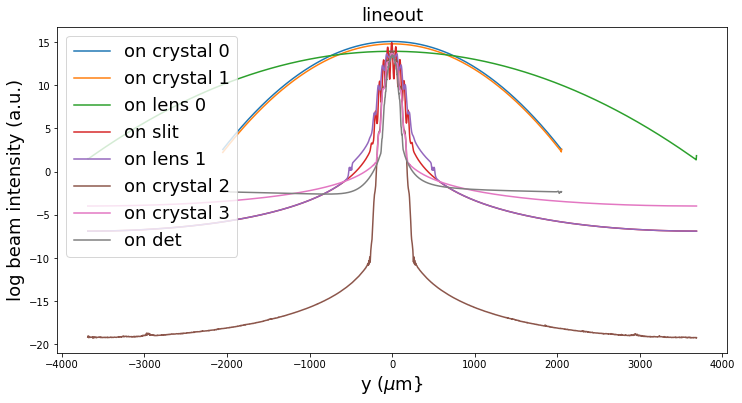

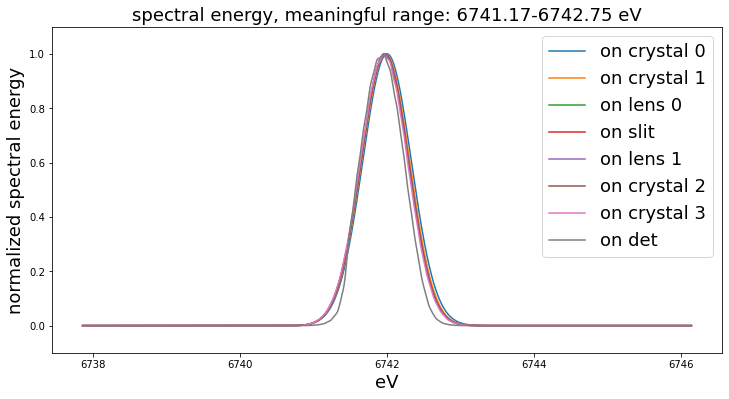

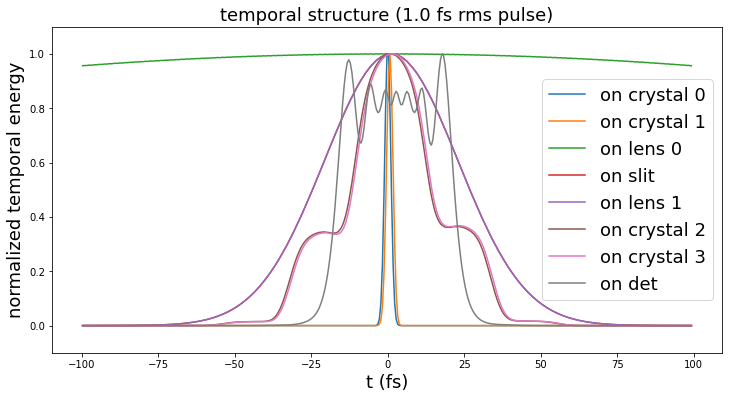

In [38]:
''' lineout everywhere '''
plt.figure(figsize=(12,6))
plot_lineout(mwf, label='on crystal 0')
plot_lineout(mwf_c1, label='on crystal 1')
plot_lineout(mwf_l0, label='on lens 0')
plot_lineout(mwf_apt, label='on slit')
plot_lineout(mwf_l1, label='on lens 1')
plot_lineout(mwf_c2, label='on crystal 2')
plot_lineout(mwf_c3, label='on crystal 3')
plot_lineout(mwf_det, label='on det')

''' spectra everywhere '''
plt.figure(figsize=(12,6))
awc0, evc0, intc0s = plot_spectra(mwf, label='on crystal 0')
awc1, evc1, intc1s = plot_spectra(mwf_c1, label='on crystal 1')
awl0, evl0, intl0s = plot_spectra(mwf_l0, label='on lens 0')
awapt, evapt, intapts = plot_spectra(mwf_apt, label='on slit')
awl1, evl1, intl1s = plot_spectra(mwf_l1, label='on lens 1')
awc2, evc2, intc2s = plot_spectra(mwf_c2, label='on crystal 2')
awc3, evc3, intc3s = plot_spectra(mwf_c3, label='on crystal 3')
awdet, evdet, intdets = plot_spectra(mwf_det, label='on det')

''' temporal profilfe everywhere '''
plt.figure(figsize=(12,6))
awc0, tc0, intc0t = plot_temporal(mwf, label='on crystal 0',fov=200e-15, pulse_duration = pulse_duration)
awc1, tc1, intc1t = plot_temporal(mwf_c1, label='on crystal 1',fov=200e-15, pulse_duration = pulse_duration)
awl0, tl0, intl0t = plot_temporal(mwf_l0, label='on lens 0',fov=200e-15, pulse_duration = pulse_duration)
awapt, tapt, intaptt = plot_temporal(mwf_apt, label='on slit',fov=200e-15, pulse_duration = pulse_duration)
awl1, tl1, intl1t = plot_temporal(mwf_l1, label='on lens 1',fov=200e-15, pulse_duration = pulse_duration)
awc2, tc2, intc2t = plot_temporal(mwf_c2, label='on crystal 2',fov=200e-15, pulse_duration = pulse_duration)
awc3, tc3, intc3t = plot_temporal(mwf_c3, label='on crystal 3',fov=200e-15, pulse_duration = pulse_duration)
awdet, tdet, intdett = plot_temporal(mwf_det, label='on det',fov=200e-15, pulse_duration = pulse_duration)